# Pro-Football 12-lead Resting Electrocardiogram Database

**Data collected**

The data were gathered from La Liga, Spain, from professional football players. 

Resting in supine position, each participantʼs 12-lead electrocardiogram (ECG) was captured with General Electrics (GE) USB-CAM 14 for a duration of 10 s at 500 Hz using the GE CardioSoft software.

## Notebook setup

In [1]:
#| code-fold: true
#| code-summary: "Click to see packages imported"
import os
import configparser
import random
import shutil
from pathlib import Path

import torch
import wfdb
import xmltodict
import numpy as np
import pandas as pd

In [2]:
#|include: false
# If the current working directory is the nbs/ folder, change to the project 
# root directory instead.
if Path.cwd().stem == "nbs":
    os.chdir(Path.cwd().parent)
print(f"The current working directory is {Path.cwd()}")

The current working directory is c:\Users\Shaun\source\Thesis\MisdiagnosisOfAthleteECG


In [3]:
#|include: false
# Import configuration settings, like location of data directory.
config = configparser.ConfigParser()
if not Path("config.ini").exists():
    print("WARNING: Please generate a config.ini file by running scripts/get_datasets.py")
else:
    config.read("config.ini")
    data_dir = Path((config["datasets"]["path"])).expanduser()
    print(f"Datasets are located at {data_dir.resolve()}")

Datasets are located at C:\Users\Shaun\source\Thesis\MisdiagnosisOfAthleteECG\data


## Convert from GE Muse XML to WFDB

https://github.com/PierreElias/IntroECG/tree/master/1-Waveform%20Extraction

In [4]:
pf12red_xml_dir = data_dir / "pf12red" / "5 163XML"
pf12red_extracted_dir  = data_dir / "pf12red" / "extracted_NSR"
pf12red_labels_file = data_dir / "pf12red" / "labels.csv"

# Start with empty directory
if pf12red_extracted_dir.exists():
    shutil.rmtree(pf12red_extracted_dir)
pf12red_extracted_dir.mkdir()

In [5]:
labels_df = pd.read_csv(pf12red_labels_file)
labels_df.head()

,AthleteID,SR,SB,iRBBB
0,1,NaN,X,X
1,2,X,NaN,NaN
2,3,NaN,X,X
3,4,NaN,X,NaN
4,5,NaN,X,NaN


In [6]:
labels_df[labels_df.AthleteID == 10]

,AthleteID,SR,SB,iRBBB
9,10,NaN,X,NaN


In [7]:
(labels_df[labels_df.AthleteID == 10].SB == "X").item()

True

In [8]:
for file in pf12red_xml_dir.iterdir():
    # Only process XML files
    if file.suffix != '.XML':
        print(f"How did {file} get there?")
        continue
    
    # Attempt to parse XML file using xmltodict package
    with open(file, 'rb') as f:
        xml_str = f.read().decode('utf8')
    try:
        xml_dict = xmltodict.parse(xml_str)
    except:
        print(f"Couldn't parse {file}")
    
    # Extract patient info
    age = xml_dict['CardiologyXML']['PatientInfo']['Age']['#text']
    gender = xml_dict['CardiologyXML']['PatientInfo']['Gender']

    # Extract diagnosis info (save as SNOMED-CT codes)
    athlete_id = int(file.stem.split('_')[0])
    labels = labels_df[labels_df.AthleteID == athlete_id]
    dx_comment = "Dx: "
    # TODO: What does SR label mean?
    if (labels.SR == 'X').item():
        dx_comment += "426783006"   # Normal sinus rhythm
        # dx_comment += "427393009"   # Sinus arrhythmia
    if (labels.SB == 'X').item():
        dx_comment += "426177001,"
    if (labels.iRBBB == 'X').item():
        dx_comment += "713426002,"

    # Extract lead waveforms (version 1)
    lead_samples = []
    for i in range(12):
        # sample_str = xml_dict['CardiologyXML']['RestingECGMeasurements']['MedianSamples']['WaveformData'][i]['#text']
        sample_str = xml_dict['CardiologyXML']['StripData']['WaveformData'][0]['#text']
        sample_list = list(map(int, sample_str.split(',')))
        lead_samples.append(np.array(sample_list, dtype=int))
    p_signal = np.stack(lead_samples) * 0.005
    p_signal= p_signal.transpose()
    
    # Write new WFDB record
    # print(f"Writing {file.stem}")
    try:
        wfdb.wrsamp(
            file.stem, 
            fs=500, 
            units=['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'],
            sig_name=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],
            p_signal=p_signal,
            comments=[f"age: {age}", f"gender: {gender}", f"{dx_comment}"],
            write_dir=pf12red_extracted_dir,
        )
    except:
        print(f"Couldn't write {file.stem}")
        garbage_record = (pf12red_extracted_dir / file.stem)
        if garbage_record.with_suffix('.hea').exists():
            garbage_record.with_suffix('.hea').unlink()
            print("Removed garbage .hea file")
        if garbage_record.with_suffix('.dat').exists():
            garbage_record.with_suffix('.dat').unlink()
            print("Removed garbage .dat file")

Couldn't write 11_1920Pre
Removed garbage .hea file
Couldn't write 13_1920Pst
Removed garbage .hea file
Couldn't write 14_1920Pst
Removed garbage .hea file
Couldn't write 19_1920Pst
Removed garbage .hea file
Couldn't write 1_1819Pst
Removed garbage .hea file
Couldn't write 20_1819Pst
Removed garbage .hea file
Couldn't write 22_1920Pst
Removed garbage .hea file
Couldn't write 23_1920Pst
Removed garbage .hea file
Couldn't write 24_1819Pst
Removed garbage .hea file
Couldn't write 2_2021Pre
Removed garbage .hea file
Couldn't write 30_1920Pst
Removed garbage .hea file
Couldn't write 30_2122Pre
Removed garbage .hea file
Couldn't write 32_1920Pst
Removed garbage .hea file
Couldn't write 33_1920Pre
Removed garbage .hea file
Couldn't parse data\pf12red\5 163XML\35_2122Pre.XML
Couldn't write 37_1920Pre
Removed garbage .hea file
Couldn't write 37_2021Pre
Removed garbage .hea file
Couldn't write 3_1920Pre
Removed garbage .hea file
Couldn't write 48_1920Pre
Removed garbage .hea file
Couldn't write 

In [9]:
# What should the p_signal look like?
norwegian_dataset_dir = data_dir / "norwegian-athlete-ecg" / "1.0.0"
record = wfdb.rdrecord(norwegian_dataset_dir / "ath_001")
record.p_signal.shape

(5000, 12)

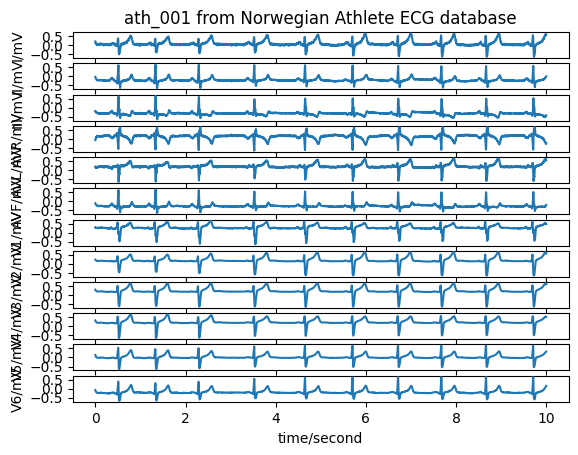

In [10]:
wfdb.plot_wfdb(record=record, title='ath_001 from Norwegian Athlete ECG database')

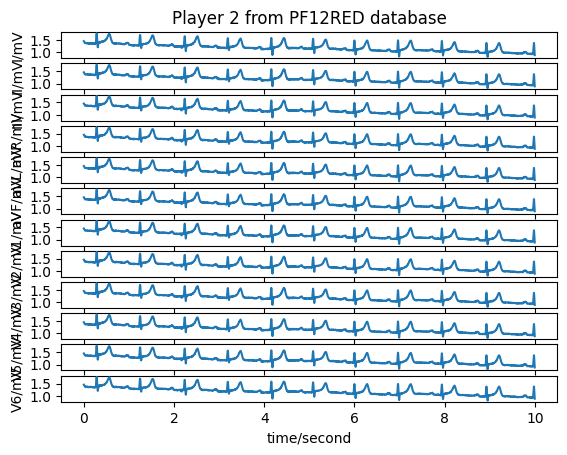

In [11]:
record = wfdb.rdrecord(pf12red_extracted_dir / "2_1819Pst")
wfdb.plot_wfdb(record=record, title='Player 2 from PF12RED database')

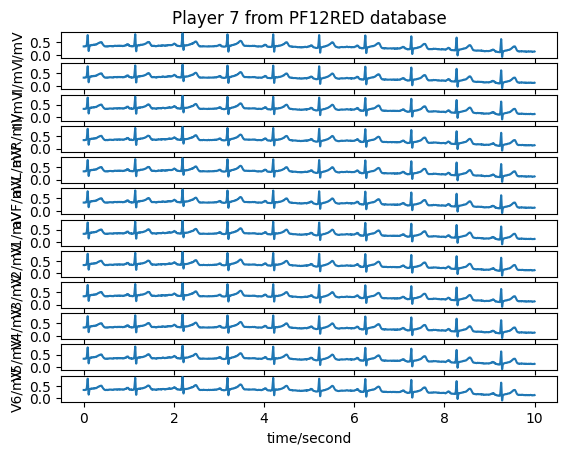

In [12]:
record = wfdb.rdrecord(pf12red_extracted_dir / "7_2122Pre")
wfdb.plot_wfdb(record=record, title='Player 7 from PF12RED database')

## Extracting waveform from PDF